In [193]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import random

In [177]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out

    def __radd__(self, other):
        return self + other

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
            
        return out

    def __rmul__(self, other): # other * self
        return self * other

    def __pow__(self, other): # self ** other
        assert isinstance(other, (int, float)), "only supporting int/float for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * self.data**(other - 1) * out.grad
        out._backward = _backward

        return out

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __neg__(self): # -self
        return self *-1

    def __sub__(self, other): # self - other
        return self + (-other)             

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1-t**2) * out.grad
        out._backward = _backward
        
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad

        out._backward = _backward
        return out
        

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        topo
        
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
            

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c  =Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label= 'd'
f = Value(-2.0, label='f')
L = d * f; L.label='L'
L

Value(data=-8.0)

In [69]:
from graphviz import Digraph

def trace(root):
    # builds a set of nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child,v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = Left to Right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name=uid, label= "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node for n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

        

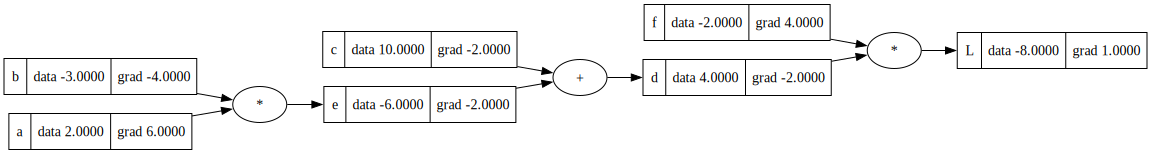

In [93]:
draw_dot(L)

In [94]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a*b
d = c+e
L=d*f
print(L.data)

-7.286496


In [91]:
def lol():

    h  = 0.001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c  =Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label= 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label='L'
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0 + h, label='b')
    c  =Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label= 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label='L'
    L2 = L.data

    print((L2-L1)/h)

lol()

-3.9999999999995595


In [180]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1+x2w2; x1w1x2w2.label='x1w1x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label='o'
o.backward()

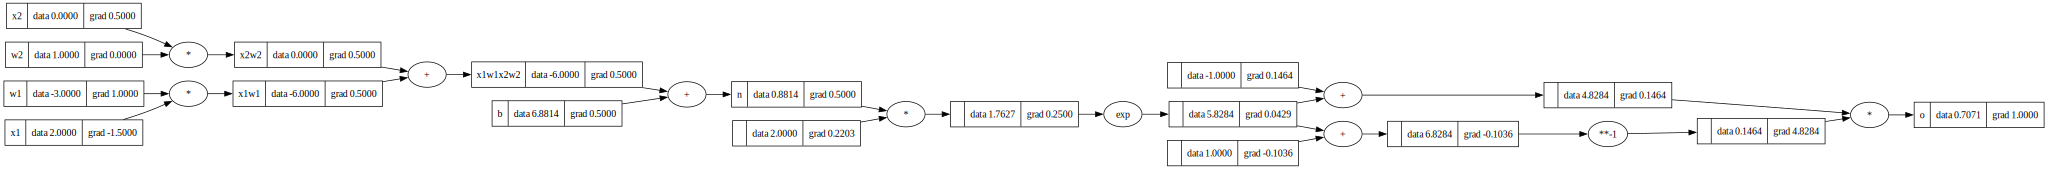

In [184]:
draw_dot(o)

In [255]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1+x2w2; x1w1x2w2.label='x1w1x2w2'
n = x1w1x2w2 + b; n.label = 'n'
#----------
e = (2*n).exp()
o = (e - 1) / (e + 1)
#----------
o.label='o'
o.backward()

In [163]:
[method for method in dir(str) if method[:2]=='__']

['__add__',
 '__class__',
 '__contains__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getnewargs__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__mod__',
 '__mul__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rmod__',
 '__rmul__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__']

In [189]:
import torch

x1 = torch.Tensor([2.0]).double()                          ; x1.requires_grad=True
x2 = torch.Tensor([0.0]).double()                          ; x2.requires_grad=True
w1 = torch.Tensor([-3.0]).double()                         ; w1.requires_grad=True
w2 = torch.Tensor([1.0]).double()                          ; w2.requires_grad=True
b = torch.Tensor([6.8813735870195432]).double()            ; b.requires_grad=True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('-----')
print('x1', x1.grad.item())
print('x2', x2.grad.item())
print('w1', w1.grad.item())
print('w2', w2.grad.item())


0.7071066904050358
-----
x1 -1.5000003851533106
x2 0.5000001283844369
w1 1.0000002567688737
w2 0.0


In [282]:
class Neuron:

    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        # w*x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer:

    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


In [343]:
x = [2.0,3.0, -1.0]
n = MLP(3, [4,4,1])
n(x)

Value(data=-0.6516871626514654)

In [344]:
# Forward pass
ypred = [n(x) for x in xs]
ypred
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])

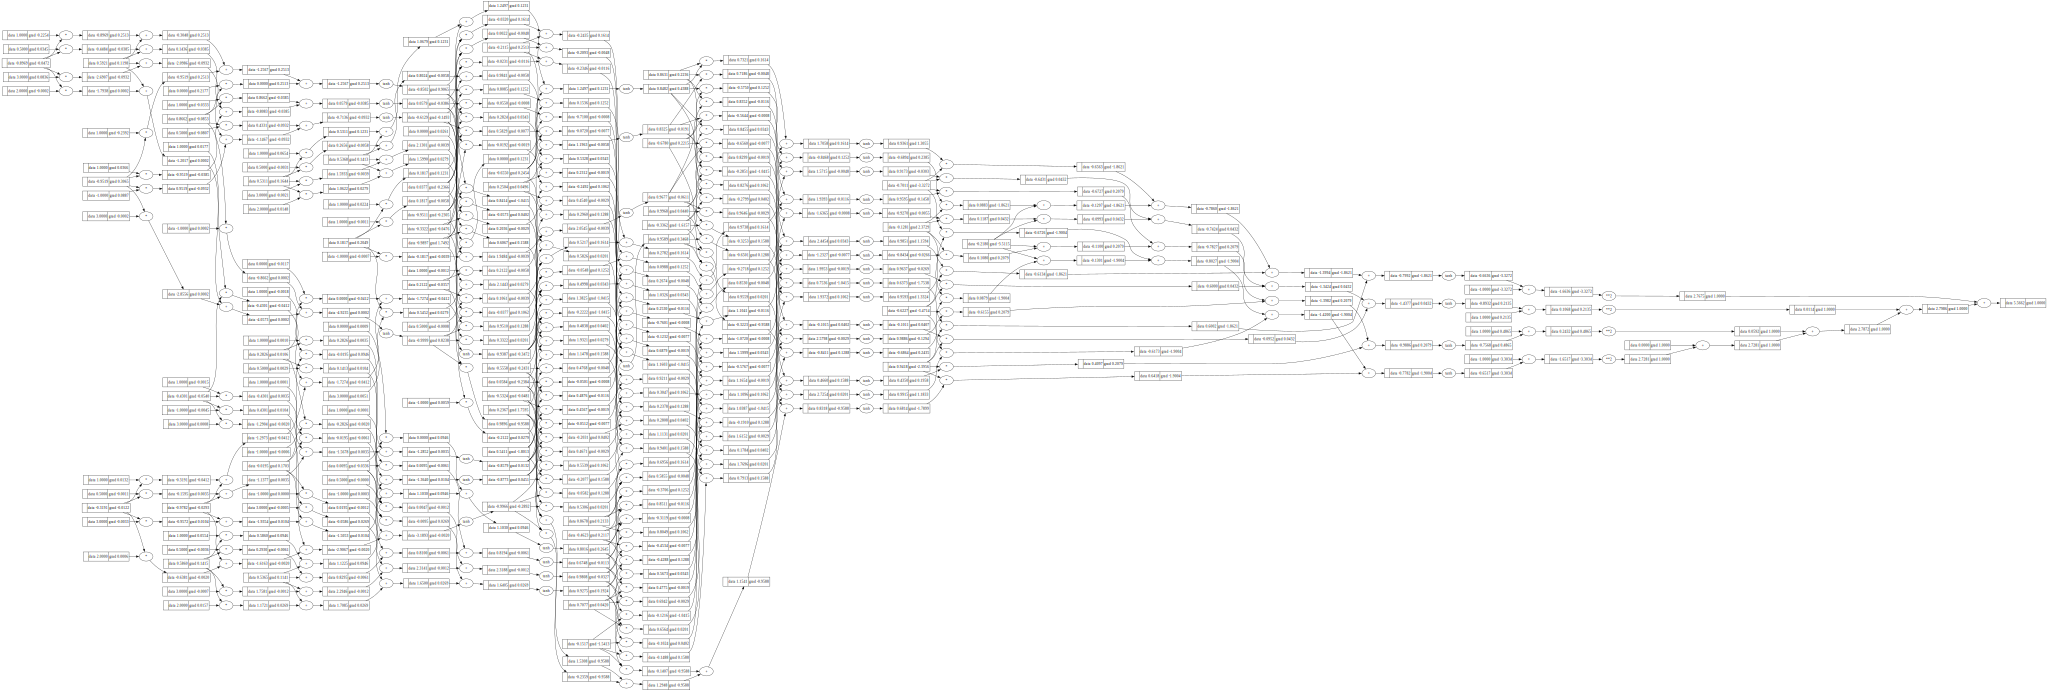

In [347]:
draw_dot(loss)

In [346]:
loss.backward()

In [334]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1,0, -1,0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [335]:
with np.printoptions(precision=4, suppress=True, threshold=8):
   for i in range(100):

        # Forward pass
        ypred = [n(x) for x in xs]
        loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
        print(f"{i} \t loss:{loss.data}")

        # Backpropagation
        for p in n.parameters():
            p.grad = 0                # ALWAYS REMEMBER TO .ZERO_GRAD() BEFORE .BACKWARD() !!!!!!
        loss.backward()

        # Gradient Descent
        for p in n.parameters():
            p.data += -0.1*p.grad

       

0 	 loss:2.0147727249997778
1 	 loss:3.788554856285334
2 	 loss:0.2968578216063948
3 	 loss:0.1808394224962822
4 	 loss:0.12781516267964174
5 	 loss:0.09796661683336871
6 	 loss:0.07899331926754821
7 	 loss:0.06593841911149513
8 	 loss:0.056440814626626264
9 	 loss:0.04923959756263642
10 	 loss:0.04360275124007093
11 	 loss:0.03907733518144115
12 	 loss:0.035368635413881785
13 	 loss:0.03227692396115186
14 	 loss:0.029662214550100704
15 	 loss:0.02742357981127077
16 	 loss:0.025486478507152882
17 	 loss:0.023794701029714493
18 	 loss:0.022305086430912568
19 	 loss:0.02098396119208261
20 	 loss:0.019804680287686588
21 	 loss:0.018745892916244226
22 	 loss:0.01779029597058418
23 	 loss:0.01692372274630828
24 	 loss:0.01613446645760409
25 	 loss:0.015412771044120978
26 	 loss:0.01475044302559668
27 	 loss:0.014140552189358231
28 	 loss:0.013577198318050793
29 	 loss:0.01305532760046849
30 	 loss:0.012570586832164412
31 	 loss:0.01211920665298312
32 	 loss:0.011697907307314272
33 	 loss:0.

In [336]:
ypred

[Value(data=0.9895697124639257),
 Value(data=-0.9837637281470909),
 Value(data=-0.9590604850712895),
 Value(data=0.9636498949034964)]

In [350]:
!dir

 Volume in drive C has no label.
 Volume Serial Number is 682A-F56C

 Directory of C:\Users\victo\OneDrive - Nova SBE\NOVA 2.Semester\machine_learning\andrej\micrograd

17.04.2024  14:54    <DIR>          .
15.04.2024  11:28    <DIR>          ..
15.04.2024  20:08    <DIR>          .ipynb_checkpoints
17.04.2024  14:54           954ÿ573 micrograd.ipynb
15.04.2024  20:08                 0 untitled.py
               2 File(s)        954ÿ573 bytes
               3 Dir(s)  405ÿ321ÿ166ÿ848 bytes free
